In [ ]:
!pip install -U datasets diffusers einops

# Simple Diffusion

This is a notebook to inspect some interesting aspects of Diffusion Model training from a simplified point of view. There are multiple superb blogs and papers discussing the underlying mathematics and derivations of diffusion models. However, sparingly few explain in layman terms how the hyper parameters they chose relate to this theory. 

So this notebook will take the opposite approach. Under the assumption that the math is indeed correct and is correctly implemented by an underlying library (which we will attempt NOT to modify unless needed), we will take an empirical approach and try various things to try to make-or-break a diffusion training recipe.

Hopefully, this will help us determine sosme simplified ways to deal with trivial diffusion training tasks on toy data. From there, one can follow the literature and learnings from this process, and scale up to real world datasets.

In this notebook, we will develop a standard model, use a simple pipeline from Hugging Face Diffusers, and train a model on a single multivariate sequence, try to train it to convergence (MSE ~ 1e-3 or lower on CPU training), generate some samples from the trained model, and in due process, hopefully understand all minute details required to enable stable training (at least on a toy dataset).

**Note: This is NOT a notebook to understand the underlying mathematics of Diffusion Models.** As mentioned above, there are plenty of much more appropriate resources in various posts and papers.

Topics covered :

- Importance of model design
- Importance of normalization of data
- Role played by $\beta$ when setting up Diffusion Scheduler
- Creation of custom Sampling Pipeline for Sequence generation task
- How to overfit a single training sample with Diffusion Training
- Improving the efficiency of single sample fitting
- Sampling 


In [ ]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from dataclasses import dataclass
from typing import Union, Optional

import torch
from torch import nn, einsum
import torch.nn.functional as F

# Model Architecture - GPT

Commonly, U-Nets are used in literature with various modifications made to either location of attention blocks, number of strides, number of filters in each layer, how to add conditional information etc. 

Vision Transformers show that training on image patches and applying standard Transformer layers works as well. [Diffusion Transformer](https://arxiv.org/abs/2212.09748) takes this idea and applies Transformers to Diffusion Generative modelling task. It requires some minor modifications and is applied to latent space (effectively doing latent diffusion to avoid the cost of attention blocks on high resolution images; though the authors suggest it can be modified to apply directly on image diffusion rather than latents).

For a single sample, we do not need such complexity. The single datapoint will be a 12-channel 26-timestep sequence, and the memory cost is trivially small enough to not even require subsampling. So we will directly apply a very small GPT network to the problem. Note: The code for the model is ported from nanoGPT.

This still apparantly posed sufficient problems which I'll discuss below:

- ``SelfAttention`` : Causal padding will ensure model fails to train on even a single sample. Had to remove causal padding entirely.

- ``Block`` : Unlike Conv-based U-Nets where the Diffusion Time features are passed to every block, GPT does not need this. In fact, while it can be added back by uncommenting the line in forward - it will actually cause the model to converge slower. 

- ``SinusoidalPosEmb`` : While the general positional embedding can be either Absolute Sinusodial embeddings, or learned embeddings, when discussing the embedding for the Diffusion timestep itself - Sinusodial PE was quite necessary. Learned embedding did far worse (at least for single sample diffusion). Interestingly, swapping sine() with cos() in the final concat step has seemingly no effect on training for a single sample.

- ``PositionalEmbedding`` : Some works apply a small FF network after the Sinusodial Positional Embedding. This was not strictly necessary for a single image, but does help if you try to fit an entire dataset with a tiny number of parameters.

- ``GPT - Diffusion Time Embedding`` : For the GPT code, you must provide some form of diffusion time embedding to denote which timestep the current sample is at. For example, if you follow the line ``time_emb = self.transformer.wpe(time).unsqueeze(1) # time embeddings of shape (time, 1, D); len(time) = B`` with ``time_emb = torch.zeros_like(time_emb)`` - you are guarenteed to be unable to train your model. Nothing I tried could make the model train.

- ``GPT - Positional Embedding (Sequence Embedding)`` : Even for this simple task of overfitting a single sample, positional encodings (learned or sinusodial) are mandatory. Try to zero them out (or simply remove seq_emb from the addition in ``x = self.transformer.drop(inp_emb + seq_emb)`` to completely halt training. Nothing I tried could make the loss reduce below a very high value.

- ``Param Count``: For a single sample, we can get away with very few trainable parameters (discounting the parameters of the large embedding matrices since we do not train on all timesteps).

Reference: https://github.com/karpathy/nanoGPT 

In [ ]:
def new_gelu(x):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class SelfAttention(nn.Module):

    def __init__(self, n_embd: int, n_head: int, dropout: float = 0.0):
        super().__init__()
        assert n_embd % n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        
        self.n_head = n_head
        self.n_embd = n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, n_embd: int, dropout: float = 0.0):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd)
        self.c_proj  = nn.Linear(4 * n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = new_gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, n_embd: int, n_head: int, dropout: float = 0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = SelfAttention(n_embd, n_head, dropout)
        self.ln_2 = nn.LayerNorm(n_embd)
        self.mlp = MLP(n_embd, dropout)

    def forward(self, x, t):
        # Try uncommenting below block to see if adding the diffusion timestep
        # embedding to every block benefits the quality of samples or not.
        # x = x + t
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


# Added block
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, max_timesteps: int = 10000):
        super().__init__()
        self.dim = dim
        self.max_timesteps = float(max_timesteps)

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.max_timesteps) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class PositionalEmbedding(nn.Module):

    def __init__(self, dim, max_timesteps: int):
        super().__init__()
        self.pe = SinusoidalPosEmb(dim=dim, max_timesteps=max_timesteps)

        # Try uncommenting the follwing and the forward step to see whether learned 
        # embeddings lead to a better result.

        # self.ff1 = nn.Linear(dim, dim * 4)
        # self.gelu = nn.GELU()
        # self.ff2 = nn.Linear(dim * 4, dim)

    def forward(self, x):
        out = self.pe(x)
        # out = self.ff2(self.gelu(self.ff1(out)))
        return out
        

@dataclass
class GPTConfig:
    dim: int
    block_size: int = 10000
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 128
    dropout: float = 0.1

class GPT(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            input_proj = nn.Linear(config.dim, config.n_embd, bias=False),
            wte = nn.Embedding(config.block_size, config.n_embd),
            wpe = PositionalEmbedding(config.n_embd, max_timesteps=config.block_size),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(n_embd=config.n_embd, n_head=config.n_head, dropout=config.dropout) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
            output_proj = nn.Linear(config.n_embd, config.dim, bias=False),
        ))

        # report number of parameters
        n_params = sum(p.numel() for p in self.parameters())
        embd_params = sum(p.numel() for p in self.transformer.wte.parameters())
        print("Total number of parameters: %.2fM" % (n_params/1e6,))
        print("Non-Embedding number of parameters: %.2fM" % ((n_params - embd_params)/1e6,))
        print("Embedding number of parameters: %.2fM" % (embd_params/1e6,))

    def forward(self, x, time):
        device = x.device
        b, d, t = x.size()  # [B, C, T]

        assert d == self.config.dim, f"Expected input dim {self.config.dim} got {d}"

        time = time.to(dtype=torch.long, device=device) # torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)
        if time.ndim == 0:
          time = time.unsqueeze(0).repeat(b)

        assert x.size(0) == time.size(0), f"Time ({len(time)}) and input batch size ({len(x)}) must match"

        # forward the GPT model itself
        x_input = x
        
        x = x.transpose(1, 2)  # [B, T, C]
        inp_emb = self.transformer.input_proj(x)  # [B, T, D]
        seq_emb = self.transformer.wte(torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)) # [1, t, D]
        time_emb = self.transformer.wpe(time).unsqueeze(1) # time embeddings of shape (time, 1, D); len(time) = B

        # You can try to remove `seq_emb` from the following line to see the model fail to converge and generate any samples at all.
        x = self.transformer.drop(inp_emb + seq_emb)

        for block in self.transformer.h:
            # To see the necessity of the diffusion time emb, you can multiply it
            # with 0 to get a model that has no conditioning on the diffusion timestep.
            x = block(x, time_emb)
        x = self.transformer.ln_f(x)
        x_out = self.transformer.output_proj(x)
        x_out = x_out.transpose(1, 2)
        
        x = x_input + x_out

        return x

    # Add two properties used by HF Sampling Pipeline
    @property
    def dtype(self):
      return next(self.parameters()).dtype

    @property
    def device(self):
      return next(self.parameters()).device

# Preparing a Dataset

In this example, we will be using a tiny speech recognition dataset for Japanese vowels rather than the usual image diffusion. We chose such a task specifically because image diffusion has been studied extensively, and usually training even a single image diffusion model on CPU would take a non trivial amount of compute or memory.

We will use the [Japanese Vowels dataset](https://archive.ics.uci.edu/ml/datasets/Japanese+Vowels), where each sample is a multivariate time series comprising of 12 LPC cepstrum coefficients over a of 26 frames. The amount of compute required to train on this data is trivial compared to even a single 256x256 image.

Most importantly, though the dataset has 12 coefficients, we can easily visualize a single channel as a basic line plot, and we will later see that this sequence has a distinctive signature which we will task the diffusion model of learning.

## Downlaod processed dataset

This dataset is already processed as part of prior research for multivariate time series classification tasks at my repository, so we will simply download and use the processed numpy arrays. 

In [ ]:
import os

if not os.path.exists("/content/JapaneseVowels-20180329T000739Z-001.zip"):
  !wget https://github.com/titu1994/MLSTM-FCN/releases/download/v1.0/JapaneseVowels-20180329T000739Z-001.zip

In [ ]:
import zipfile
import os

dataset_root = "dataset/"
os.makedirs(dataset_root, exist_ok=True)

with zipfile.ZipFile('JapaneseVowels-20180329T000739Z-001.zip', 'r') as zip_ref:
  zip_ref.extractall(dataset_root)

## Normalize the dataset

In almost all literature for diffusion models, the standard practice is to normalize the input to be within the range [-1, 1], so we will do the same for this dataset.

A simple study can be to change this to mean-std normalization instead.

In [ ]:
import numpy as np

jp_root = os.path.join(dataset_root, "JapaneseVowels")

x_train = np.load(os.path.join(jp_root, "X_train.npy"))  # [B, C, T]
x_test = np.load(os.path.join(jp_root, "X_test.npy"))  # [B, C, T]

# Normalize dataset to [-1, 1] range
x_train = (x_train - x_train.min(-1, keepdims=True)) / (x_train.max(-1, keepdims=True) - x_train.min(-1, keepdims=True))
x_train = 2 * x_train - 1

x_test = (x_test - x_test.min(-1, keepdims=True)) / (x_test.max(-1, keepdims=True) - x_test.min(-1, keepdims=True))
x_test = 2 * x_test - 1

# Convert dataset to tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

channels = x_train.shape[1]
timesteps = x_train.shape[2]

print("Loaded X Train :", x_train.shape, "Max", x_train.max(), "Min", x_train.min())
print("Loaded X Test  :", x_test.shape, "Max", x_test.max(), "Min", x_test.min())

Loaded X Train : torch.Size([270, 12, 26]) Max tensor(1.) Min tensor(-1.)
Loaded X Test  : torch.Size([370, 12, 26]) Max tensor(1.) Min tensor(-1.)


# Check model forward pass

Given a dataset and a model, lets make sure that the forward pass works as expected.

Note: For a single sample, we wont be using millions of parameters, a few hundred thousand (or less) will be sufficient.

In [ ]:
config = GPTConfig(dim=channels, n_embd=32, n_head=4, n_layer=4, dropout=0.0)
model = GPT(config)

Total number of parameters: 0.37M
Non-Embedding number of parameters: 0.05M
Embedding number of parameters: 0.32M


In [ ]:
with torch.no_grad():
  tmp_ip = x_train[0:8]
  out = model(tmp_ip, time=torch.tensor(list(range(8)), dtype=torch.long))
  print("Input  :", tmp_ip.shape)
  print("Output :", out.shape)

Input  : torch.Size([8, 12, 26])
Output : torch.Size([8, 12, 26])


# Diffusion Scheduler

We will use the simple diffusion scheduler from the [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) that has been implemented in [Hugging Face](https://huggingface.co/docs/diffusers/api/schedulers/ddpm).

We will make a small modification to the paper, which is to change the number of diffusion steps from 1000 to something manageable, such as 50 or 100. This is for two purposes - 

1) There's not much examples out there exploring how to make the train schedule itself require smaller number of diffusion steps - its usually in the order of hundreds or sticks to the defaults in the paper (1000 or more steps). 

2) Very few works mention exactly how they select the parameters of $\beta_{start}$ and $\beta_{end}$ for the linear scheduler, which is commonly used (although there is a shift towards continous time discretization which resolves the matter).

-----

For this example, since we want to train the model quickly on a single sample only, it would be preferable to limit the amount of compute and optimizer updates required to achieve this. One simple method is to reduce the size of the Markov chain that defines the diffusion process - simply reduce the diffusion timesteps.

It is to be noted that the model will learn a better result with more diffusion steps, usually. But it will also exacerbate the inference cost which will require thousands of passes of the model to generate a single batch of images.


## How to select $\beta$ range?

First we need to note that $\beta$ is not directly used for the forward process (when converting data to gaussian noise). Instead we use $\alpha$ which can be defined as 

\begin{align}
  \alpha_t &= 1 - \beta_t \\
  \bar{\alpha}_t &= \prod_{s=1}^t \alpha_s
\end{align}

Another thing to note is that optimally, at step $t=T$ where $T$ is the number of diffusion steps, the input data should be nearly gaussian noise $\mathcal{N}(0, 1)$. 

However, when we change $T$, we also substantially affect $\alpha_t$ and $\bar{\alpha}_t$, which can lead to the output of the diffusion process not being similar to gaussian noise, thereby making the reverse diffusion process more difficult (intuitively, if your image is not completely noise, you would need a partially noisy image as your initial guess when sampling).

In [ ]:
from diffusers import DDPMScheduler
from diffusers.schedulers.scheduling_ddpm import DDPMSchedulerOutput
from diffusers.utils import randn_tensor

# Setup Constants
DIFFUSION_TIMESTEPS = 50  # Number of Diffusion Steps during training. Note, this is much smaller than ordinary (usually ~1000)
beta_start = 0.0001  # Default from paper
beta_end = 0.2  # NOTE: This is different to accomodate the much shorter DIFFUSION_TIMESTEPS (Usually ~1000). For 1000 diffusion timesteps, use 0.02.
clip_sample = True  # Used for better sample generation

noise_scheduler = DDPMScheduler(num_train_timesteps=DIFFUSION_TIMESTEPS, beta_end=beta_end, clip_sample=clip_sample)
noise_scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.12.1",
  "beta_end": 0.2,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "num_train_timesteps": 50,
  "prediction_type": "epsilon",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

## Checking the validity of the noise schedule

Since we change ``DIFFUSION_TIMESTEPS``, we must in turn modify $\beta_{end}$ to ensure the diffusion process results in gaussian noise as the output. Remember that from Equation 14 in the DDPM paper, we effectively optimize the following - 

\begin{align}
  \| \left(  ϵ - ϵ_θ (\sqrt{\bar{\alpha_t}} x_0 + \sqrt{1 - \bar{\alpha_t}} ϵ, t ) \right) \|^2 
\end{align}

A simple way to accomplish this is to first modify $T$ to a required value, then to modify $\beta_{end}$ in order to observe the final values of $\sqrt{\bar{\alpha_t}}$ and $\sqrt{1 - \bar{\alpha_t}}$ to ensure they are close to 0 and 1 respectively. In doing so, the above $ϵ_Θ(.)$ represents gaussian noise alone.

You may modify the ``DIFFUSION_TIMESTEPS`` ($T$) and $\beta_{end}$ parameters above to observe the printed values. If they are not close to 0 and 1 respectively, the model may not converge properly.

### Alpha Cumulative Product Ranges

In [ ]:
print(torch.sqrt(noise_scheduler.alphas_cumprod))
print(torch.sqrt(1. - noise_scheduler.alphas_cumprod))

tensor([0.9999, 0.9979, 0.9937, 0.9876, 0.9794, 0.9693, 0.9574, 0.9435, 0.9280,
        0.9107, 0.8919, 0.8716, 0.8500, 0.8271, 0.8031, 0.7781, 0.7522, 0.7256,
        0.6984, 0.6708, 0.6428, 0.6146, 0.5864, 0.5581, 0.5301, 0.5023, 0.4749,
        0.4479, 0.4216, 0.3958, 0.3708, 0.3465, 0.3231, 0.3005, 0.2789, 0.2582,
        0.2385, 0.2197, 0.2020, 0.1852, 0.1694, 0.1546, 0.1407, 0.1278, 0.1157,
        0.1046, 0.0942, 0.0847, 0.0760, 0.0679])
tensor([0.0100, 0.0654, 0.1118, 0.1571, 0.2017, 0.2457, 0.2889, 0.3312, 0.3727,
        0.4130, 0.4522, 0.4902, 0.5268, 0.5621, 0.5959, 0.6282, 0.6589, 0.6881,
        0.7157, 0.7417, 0.7660, 0.7888, 0.8101, 0.8297, 0.8479, 0.8647, 0.8800,
        0.8941, 0.9068, 0.9183, 0.9287, 0.9380, 0.9464, 0.9538, 0.9603, 0.9661,
        0.9711, 0.9756, 0.9794, 0.9827, 0.9855, 0.9880, 0.9901, 0.9918, 0.9933,
        0.9945, 0.9956, 0.9964, 0.9971, 0.9977])


### Sampled Variance Range

An important side-effect of increasing $\beta_{end}$ is the variance added to generated samples during the reverse process. 

Recall that for the reverse process, we need to compute the predicted variance $\beta_t$ (See Equation 6 and 7 in the DDPM paper) and sample from it to get the previous sample in the reverse process. We then scale this sample by  $\sqrt{\tilde{\beta}_t}$, such that $\tilde{\beta}_t$ is defined as follows - 

\begin{equation}
   \tilde{\beta}_t = \frac{1 - \bar{α_{t-1}}}{1 - \bar{α_t}} \beta_t
\end{equation}

The primary issue is that by scaling up the value of $\beta_{end}$, we have also scaled up the value of $\tilde{β}_t$, which affects the reverse diffusion process. 

For a trivial task as learning a single sample, it may be fine to use a large enough $\beta_t$, but for any real training of diffusion models, care must be taken to have an appropriate number of diffusion steps to manage the scale of $\tilde{\beta}_t$ during the backward process.

Note that the final value of $\tilde{\beta}_T$ will be equivalent to $\beta_{end}$, and so we can calculate whether the scaling of gaussian noise will be excessive or not.

-----

**Note**: Under the DDPM paper's guidance, $T=1000$, and so $β_{end} = 0.02$ so $\tilde{\beta}_T = \sqrt{0.02} = 0.1414 ⋯$.

In [ ]:
variance_ = []
for t in range(noise_scheduler.num_train_timesteps):
    alpha_prod_t = noise_scheduler.alphas_cumprod[t]
    alpha_prod_t_prev = noise_scheduler.alphas_cumprod[t - 1] if t > 0 else noise_scheduler.one

    # For t > 0, compute predicted variance βt (see formula (6) and (7) from https://arxiv.org/pdf/2006.11239.pdf)
    # and sample from it to get previous sample
    # x_{t-1} ~ N(pred_prev_sample, variance) == add variance to pred_sample
    variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * noise_scheduler.betas[t]
    variance_.append(variance)

variance_ = torch.tensor(variance_)
print("Pred sample Variance:", variance_.min(), " -> ", variance_.max())
print("Pred sample stdev   :", variance_.sqrt())

Pred sample Variance: tensor(0.)  ->  tensor(0.1998)
Pred sample stdev   : tensor([0.0000, 0.0099, 0.0532, 0.0791, 0.0998, 0.1176, 0.1333, 0.1476, 0.1608,
        0.1731, 0.1847, 0.1956, 0.2061, 0.2161, 0.2256, 0.2348, 0.2438, 0.2524,
        0.2607, 0.2688, 0.2767, 0.2844, 0.2919, 0.2992, 0.3063, 0.3133, 0.3202,
        0.3268, 0.3334, 0.3398, 0.3461, 0.3522, 0.3583, 0.3642, 0.3700, 0.3757,
        0.3814, 0.3869, 0.3923, 0.3977, 0.4029, 0.4081, 0.4132, 0.4182, 0.4232,
        0.4280, 0.4329, 0.4376, 0.4423, 0.4470])


### Visual check of Forward Process of Diffusion

Next, lets make sure visually that the forward diffusion step is correct. Below, you can modify $t$ to any integer value between $0$ to $T-1$ and see the progressive addition of gaussian noise to the original sequence (here we select just one channel of the model to make visualization simpler).

X noisy statistics : mean= tensor(0.0020) std= tensor(0.9286)


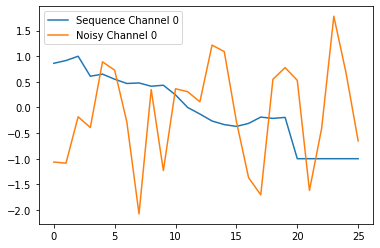

In [ ]:
# take time step as any value 0 < t < DIFFUSION_TIMESTEPS
# you can change this value to see the change of original sample to noise 
t = torch.tensor([DIFFUSION_TIMESTEPS - 1])
sequence = x_train[0:1].clone()  # We will use just a single sample throughout this tutorial

g = torch.Generator(device='cpu').manual_seed(0)
noise = torch.randn(sequence.shape, generator=g)
x_noisy = noise_scheduler.add_noise(sequence, noise, t)

plt.plot(sequence[0, 0], label='Sequence Channel 0')
plt.plot(x_noisy[0, 0], label='Noisy Channel 0')
plt.legend()

# If at final step of forward process
# X_noisy should have approximately mean=0.0 and std=1.0
if t[0] == DIFFUSION_TIMESTEPS - 1:
  print("X noisy statistics :", "mean=", x_noisy.mean(), "std=", x_noisy.std())

-----

We can create an animation to see the transformation of the input to gaussian noise progressing.

Note that with large number of diffusion timesteps, this might take some time to generate.

In [ ]:
# NOTE: The following cell can take a long time for large DIFFUSION_STEPS

from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML

# create the figure and axes objects
fig, ax = plt.subplots()

def animate_forward_process(i):
  t = torch.tensor([i])

  g = torch.Generator(device='cpu').manual_seed(0)
  noise = torch.randn(sequence.shape, generator=g)  
  x_noisy = noise_scheduler.add_noise(sequence, noise, t)

  ax.clear()
  ax.set_title(f"T={i}")
  ax.plot(sequence[0, 0], label='Sequence Channel 0')
  ax.plot(x_noisy[0, 0], label='Noisy Channel 0')
  ax.legend(loc="upper right")

# run the animation
anim = FuncAnimation(fig, animate_forward_process, frames=list(range(DIFFUSION_TIMESTEPS)), interval=200, repeat=False)

rc('animation', html='jshtml')
HTML(anim.to_jshtml())

# Custom Diffusion Pipeline for Time Series Generation

We will be using the [diffusers](https://huggingface.co/docs/diffusers/index) throughout the notebook in order to abstract away the diffusion process logic. The code for ``DDPM`` can be read in order to understand the paper better.

Here, we will write a custom ``DiffusionPipelin`` for time series data, which is mostly a replication of the ``DDPMPipeline`` with some additional arguments.

In [ ]:
from diffusers import DiffusionPipeline
from typing import List, Optional, Tuple, Union

@dataclass
class SequenceDataOutput:
  sequences: List[torch.Tensor]
  history: List[torch.Tensor]


class SequenceDDPMPipeline(DiffusionPipeline):

  def __init__(self, model: GPT, scheduler: DDPMScheduler):
    super().__init__()
    self.register_modules(model=model, scheduler=scheduler)

  @torch.no_grad()
  def __call__(self, 
        batch_size: int = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = DIFFUSION_TIMESTEPS,
        return_dict: bool = True,
        return_all: bool = False,  # new flag to return all the diffusion reverse process steps as a list
        explicit_noise: torch.Tensor = None,  # We can pass in an explicit loss value to ensure diffusion backward process is working as expected
        **kwargs,           
  ) -> SequenceDataOutput:
    self.scheduler: DDPMScheduler
    self.model: GPT

    # Get the sequence length from the notebook's globals as they were defined above when loading the dataset
    # Or use the user defined value if passed.
    # NOTE: Since we train on a single sample with exact seq_len and seq_dim, changing this will NOT work during inference.
    seq_len = kwargs.get('seq_len', timesteps)
    seq_dim = kwargs.get('channels', channels)

    # Sample noise as an init to the reverse process, if no noise was explicitly provided
    if explicit_noise is None:
      sequence_data = torch.randn(batch_size, seq_dim, seq_len, device=self.device, generator=generator)
    else:
      sequence_data = explicit_noise.to(device=device)

    # Set inference timesteps
    self.scheduler.set_timesteps(num_inference_steps=num_inference_steps)

    # Check whether to mantain the history of all reverse diffusion process steps
    if return_all:
      history = [sequence_data.cpu()]
    else:
      history = None

    for t in self.progress_bar(self.scheduler.timesteps):
        # 1. predict noise model_output
        model_output = self.model(sequence_data, t)

        # 2. compute previous image: x_t -> x_t-1  # prev_sample
        sequence_data = self.scheduler.step(model_output, t, sequence_data, generator=generator).prev_sample

        # Optional: Preserve history of intermediate step generation
        if history is not None:
          history.append(sequence_data.cpu().clone())
    
    # Clamp to allowed prediction range
    sequence_data = sequence_data.clamp(min=-1.0, max=1.0)
    
    if not return_dict:
        return (sequence_data,)

    return SequenceDataOutput(sequences=sequence_data, history=history)

# Dataloader with a Single Sample

To diffuse a single sample, we dont really need to create a PyTorch Dataset or DataLoader, but for ease of use where we may want to experiment with more than one sample (or even the entire dataset), we will write a simple data loader.

In [ ]:
BATCHSIZE = 128  # used only if you select more than one sample below

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):

  def __init__(self, X_train):
    super().__init__()

    self.data = X_train.clone()

  def __getitem__(self, idx):
    sample = self.data[idx]  # [C, T]
    return sample

  def __len__(self):
    return len(self.data)

In [ ]:
sample_idx = 0

assert 0 <= sample_idx < len(x_train), "Sample index cannot be > number of samples in train set or < 0!"
dataset = TimeSeriesDataset(x_train[sample_idx: sample_idx + 1])
dataloader = DataLoader(dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=0, pin_memory=True)
print("Dataset size :", len(dataset), "\nSingle Sample shape: ", dataset[0].shape)

Dataset size : 1 
Single Sample shape:  torch.Size([12, 26])


# Prepare Model for training

The model will learn on a single sample, so we do not need to have too many parameters or too much hyper parameter optimization. Standard Adam optimizer with a cosine schedule to lower the LR for 1000 steps should be enough.

In [ ]:
from torch.optim import Adam
from diffusers.optimization import get_cosine_schedule_with_warmup

epochs = int(1e3)  # 1000 'epochs' seems a lot, but with single sample in the dataset, 1 epoch = 1 update step
num_steps = len(dataloader) * epochs

device = "cuda" if torch.cuda.is_available() else "cpu"

# Create small model with ~ 400,000 params (non embedding)
# NOTE: Such a small model is OK since we are training on a single sample
#       We would need to increase model size to train on the entire dataset !
config = GPTConfig(dim=channels, n_embd=128, n_head=4, n_layer=2, dropout=0.0)
model = GPT(config)
model.to(device)

# Since we will train on a single sample, we can use very high LR to converge faster with certain tricks
optimizer = Adam(model.parameters(), lr=1e-2, betas=[0.9, 0.999])

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_steps,
)

Total number of parameters: 1.68M
Non-Embedding number of parameters: 0.40M
Embedding number of parameters: 1.28M


-------

You can uncomment the following line and perhaps change the path to load a pretrained checkpoint (after training at least one model).

In [ ]:
# Load previous checkpoint if necessary
# model.load_state_dict(torch.load("/content/checkpoints/jp_vowels.pt"))

# Training

Training of a DDPM model is relatively simple and can be broken down into 3 steps - 

1) Sample a batch of input tensors $x$, a corresponding batch of integers corresponding to diffusion timesteps $t$, and gaussian noise $\mathcal{N}(0, 1)$ of the same shape as $x$ (lets call it $ϵ$). 

------

2) Compute $x_t$ from $x_0$, $t$ and $ϵ$ as follows - 

\begin{align}
  res &= ϵ_θ (\sqrt{\bar{\alpha_t}} x_0 + \sqrt{1 - \bar{\alpha_t}} ϵ, t)
\end{align}

where $θ$ is the parameters of the model that predicts previous noise $ϵ_θ$ given the conditioning input of diffusion timestep $t$ along with the forward diffusion process at current timestep.

------

3) Compute the loss as follows and backprop - 

\begin{align}
  loss &= \| \left( ϵ - res  \right) \|
\end{align}

------




For a single sample, the diffusion model must learn the following (vastly simplified) -

* Map a single timestep $t \: ; 0 \le t < T$
* And a single input data point of shape $\mathbb{R}^{C \times T}$, to which noise $ϵ$ is added according to the diffusion schedule $β$
* To $ϵ$ itself

In this scenario, we have three sources of randomness - 
* The sampled input datapoint
* The timestep $t$ that defines the diffusion timestep of this step
* The gaussian noise that must be predicted $ϵ$

During diffusion model training over real datasets, training is memory bound due to the size of the tensors for $x$ and $ϵ$, along with the model's forward-backward pass + gradients. Therefore there is no choice but to sample $t$.

Intuitively, it can be considered that for a single given $x_{sample}$ - you can sample *any* $t$, and independently sample *any* $\epsilon$ to perform a single gradient update. 

While $t$ is constrained to a finite set of values, $T$ can be very large (usually $1000$) and so you would need a large number of update steps to sample all possible $t$.

Furthermore, for any given $t$, you can sample nearly infinite variations of gaussian noise $\epsilon$ - so the model would need a large number of update steps if we trained it on a single $t$ and a single $ϵ$.

Fortunately, in our case $x$ is a tiny tensor of just $C=12 \times L=26$ floating point values. Furthermore, we want to train on just one single sample, so both $x_{sample}$ and $ϵ$ are both quite small.

So we can dramatically improve the efficiency of training by simply computing gaussian noise value $ϵ_t$ for all given $t \in [1,2,⋯,T]$. This way, the batch of samples now includes **all** $t$, and $t$ number of gaussian noise samples $ϵ_t \in \mathbb{R}^{T \times C \times L }$, such that the batch size is now equal to the diffusion timesteps $T$.

In [ ]:
# How many `t` to sample in a single step. Note that it can be used only when training a single sample at a time.
batch_repeat = noise_scheduler.num_train_timesteps

checkpoint_name = "jp_vowels.pt"

############################################################################
from tqdm import tqdm

model.train()

# Checkpoint saving
checkpoint_dir = '/content/checkpoints/'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir, exist_ok=True)


global_step = 0
for epoch in tqdm(range(epochs), total=num_steps, desc='Epoch'):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      # Single sample optimization : Repeat the sample such that [1, C, T] -> [arange(0, DIFFUSION_TIMESTEPS), C, T]
      # In doing so, we can parallely apply 1 random Diffusion `t` and `noise` to the same sample in a single step
      # Significantly improves convergence speed by providing multiple `t` and `noise` to calculate the loss
      if batch_repeat > 0 and batch.size(0) == 1:
        batch = batch.expand(batch_repeat, -1, -1)
      
      batch_size = batch.size(0)
      batch = batch.to(device)

      # Normal algorithm - sample t from discrete uniform distribution
      # t = torch.randint(0, noise_scheduler.num_train_timesteps, (batch_size,), dtype=torch.long, device=device)

      # Single sample optimization : Compute all values of T in a single update step
      # Explicitly compute all possible T in one shot
      t = torch.arange(0, noise_scheduler.num_train_timesteps, dtype=torch.long, device=device)

      # Noise sampling per `t` - note that each `t_i` corresponds to a different noise value of shape `[1, C, T]` !
      noise = torch.randn(batch.shape, device=device)
      noisy_sequence = noise_scheduler.add_noise(batch, noise, t)

      noise_pred = model(noisy_sequence, t)
      loss = F.mse_loss(noise_pred, noise)

      if (global_step + 1) % 100 == 0:
        print(f"Step : {global_step + 1} - LR: {optimizer.param_groups[0]['lr']:0.6f} - Loss: {loss.item()}")
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, checkpoint_name))
        
      loss_val = loss.item()
      if loss_val > 0.1:
        print("Step :", global_step + 1, "Loss:", loss_val)

      loss.backward()

      optimizer.step()
      lr_scheduler.step()

      global_step += 1

Epoch:   0%|          | 1/1000 [00:00<03:47,  4.39it/s]

Step : 1 Loss: 0.6353825926780701


Epoch:   0%|          | 2/1000 [00:00<03:38,  4.56it/s]

Step : 2 Loss: 0.6345659494400024


Epoch:   0%|          | 3/1000 [00:00<03:30,  4.73it/s]

Step : 3 Loss: 0.6089127659797668
Step : 4 Loss: 0.5889492034912109


Epoch:   0%|          | 5/1000 [00:01<03:21,  4.95it/s]

Step : 5 Loss: 0.5303691029548645
Step : 6 Loss: 0.4653708338737488


Epoch:   1%|          | 7/1000 [00:01<03:20,  4.96it/s]

Step : 7 Loss: 0.4177964925765991


Epoch:   1%|          | 8/1000 [00:01<03:18,  5.01it/s]

Step : 8 Loss: 0.36858895421028137
Step : 9 Loss: 0.3228256404399872


Epoch:   1%|          | 10/1000 [00:02<03:20,  4.95it/s]

Step : 10 Loss: 0.27296292781829834


Epoch:   1%|          | 11/1000 [00:02<03:18,  4.98it/s]

Step : 11 Loss: 0.25476425886154175
Step : 12 Loss: 0.23641778528690338


Epoch:   1%|▏         | 13/1000 [00:02<03:17,  5.01it/s]

Step : 13 Loss: 0.2364058494567871
Step : 14 Loss: 0.24291276931762695


Epoch:   2%|▏         | 15/1000 [00:03<03:19,  4.93it/s]

Step : 15 Loss: 0.24896572530269623


Epoch:   2%|▏         | 16/1000 [00:03<03:20,  4.92it/s]

Step : 16 Loss: 0.24333737790584564
Step : 17 Loss: 0.24247963726520538


Epoch:   2%|▏         | 18/1000 [00:03<03:16,  5.00it/s]

Step : 18 Loss: 0.23204512894153595
Step : 19 Loss: 0.21086406707763672


Epoch:   2%|▏         | 20/1000 [00:04<03:14,  5.04it/s]

Step : 20 Loss: 0.2172468900680542
Step : 21 Loss: 0.21148647367954254


Epoch:   2%|▏         | 22/1000 [00:04<03:14,  5.02it/s]

Step : 22 Loss: 0.2032386064529419


Epoch:   2%|▏         | 23/1000 [00:04<03:13,  5.05it/s]

Step : 23 Loss: 0.20786511898040771
Step : 24 Loss: 0.204347163438797


Epoch:   2%|▎         | 25/1000 [00:05<03:14,  5.02it/s]

Step : 25 Loss: 0.20429782569408417


Epoch:   3%|▎         | 26/1000 [00:05<03:15,  4.98it/s]

Step : 26 Loss: 0.20441271364688873
Step : 27 Loss: 0.1940452754497528


Epoch:   3%|▎         | 28/1000 [00:05<03:12,  5.06it/s]

Step : 28 Loss: 0.1997586488723755
Step : 29 Loss: 0.19126655161380768


Epoch:   3%|▎         | 30/1000 [00:06<03:12,  5.04it/s]

Step : 30 Loss: 0.183749720454216
Step : 31 Loss: 0.18710029125213623


Epoch:   3%|▎         | 32/1000 [00:06<03:12,  5.02it/s]

Step : 32 Loss: 0.17976386845111847


Epoch:   3%|▎         | 33/1000 [00:06<03:12,  5.04it/s]

Step : 33 Loss: 0.16856610774993896
Step : 34 Loss: 0.17258241772651672


Epoch:   4%|▎         | 35/1000 [00:07<03:11,  5.03it/s]

Step : 35 Loss: 0.165580615401268
Step : 36 Loss: 0.1604057103395462


Epoch:   4%|▎         | 37/1000 [00:07<03:13,  4.98it/s]

Step : 37 Loss: 0.14914779365062714


Epoch:   4%|▍         | 38/1000 [00:07<03:11,  5.02it/s]

Step : 38 Loss: 0.14997026324272156
Step : 39 Loss: 0.14982396364212036


Epoch:   4%|▍         | 40/1000 [00:08<03:08,  5.08it/s]

Step : 40 Loss: 0.13931763172149658
Step : 41 Loss: 0.13996195793151855


Epoch:   4%|▍         | 42/1000 [00:08<03:10,  5.04it/s]

Step : 42 Loss: 0.13938477635383606


Epoch:   4%|▍         | 43/1000 [00:08<03:12,  4.98it/s]

Step : 43 Loss: 0.13989731669425964


Epoch:   4%|▍         | 44/1000 [00:08<03:18,  4.82it/s]

Step : 44 Loss: 0.14016719162464142


Epoch:   4%|▍         | 45/1000 [00:09<03:15,  4.90it/s]

Step : 45 Loss: 0.13446705043315887
Step : 46 Loss: 0.12623535096645355


Epoch:   5%|▍         | 47/1000 [00:09<03:12,  4.95it/s]

Step : 47 Loss: 0.13023120164871216
Step : 48 Loss: 0.13068129122257233


Epoch:   5%|▍         | 49/1000 [00:09<03:08,  5.04it/s]

Step : 49 Loss: 0.11697565764188766
Step : 50 Loss: 0.11499913036823273


Epoch:   5%|▌         | 51/1000 [00:10<03:05,  5.11it/s]

Step : 51 Loss: 0.12304746359586716
Step : 52 Loss: 0.11837047338485718

Epoch:   5%|▌         | 52/1000 [00:10<03:07,  5.05it/s]


Step : 53 Loss: 0.11565542966127396


Epoch:   5%|▌         | 54/1000 [00:10<03:06,  5.07it/s]

Step : 54 Loss: 0.11502376943826675
Step : 55 Loss: 0.10559552162885666


Epoch:   6%|▌         | 56/1000 [00:11<03:07,  5.04it/s]

Step : 56 Loss: 0.11480468511581421


Epoch:   6%|▌         | 58/1000 [00:11<03:06,  5.05it/s]

Step : 58 Loss: 0.10558803379535675


Epoch:   6%|▌         | 60/1000 [00:12<03:06,  5.05it/s]

Step : 60 Loss: 0.10877609997987747
Step : 61 Loss: 0.11229149252176285


Epoch:   6%|▌         | 62/1000 [00:12<03:04,  5.08it/s]

Step : 62 Loss: 0.10557376593351364


Epoch:   6%|▋         | 63/1000 [00:12<03:05,  5.04it/s]

Step : 63 Loss: 0.10245098173618317


Epoch:  10%|█         | 100/1000 [00:20<03:16,  4.58it/s]

Step : 100 - LR: 0.009900 - Loss: 0.061248328536748886


Epoch:  20%|██        | 200/1000 [00:41<02:43,  4.89it/s]

Step : 200 - LR: 0.009704 - Loss: 0.040988676249980927


Epoch:  30%|███       | 300/1000 [01:01<02:22,  4.92it/s]

Step : 300 - LR: 0.008841 - Loss: 0.03838014602661133


Epoch:  40%|████      | 400/1000 [01:20<02:00,  4.96it/s]

Step : 400 - LR: 0.007515 - Loss: 0.03511390462517738


Epoch:  50%|█████     | 500/1000 [01:40<01:39,  5.03it/s]

Step : 500 - LR: 0.005885 - Loss: 0.03086070716381073


Epoch:  60%|██████    | 600/1000 [01:59<01:21,  4.91it/s]

Step : 600 - LR: 0.004149 - Loss: 0.022057991474866867


Epoch:  70%|███████   | 700/1000 [02:19<00:59,  5.03it/s]

Step : 700 - LR: 0.002515 - Loss: 0.020898127928376198


Epoch:  80%|████████  | 800/1000 [02:39<00:39,  5.05it/s]

Step : 800 - LR: 0.001181 - Loss: 0.01704450696706772


Epoch:  90%|█████████ | 900/1000 [02:58<00:19,  5.03it/s]

Step : 900 - LR: 0.000308 - Loss: 0.007782733999192715


Epoch: 100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s]

Step : 1000 - LR: 0.000000 - Loss: 0.006287605036050081


# Sampling to generate a single sequence

Now that the model has hopefully converged, we can sample from it using the custom pipeline.

Something to note : We trained the model for an exceedingly small amount of steps, and so loss is non-zero. We do expect to potentially see samples generated that do not exactly match the input sequence.

  0%|          | 0/50 [00:00<?, ?it/s]

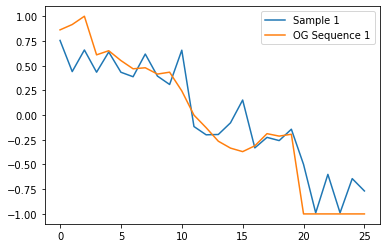

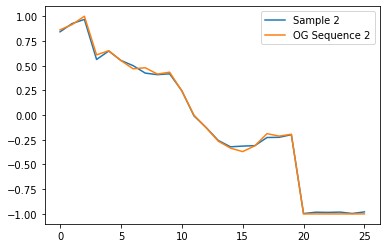

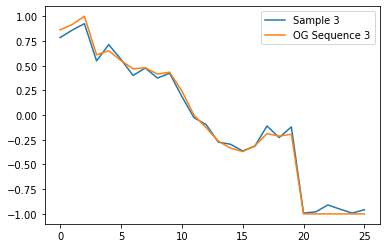

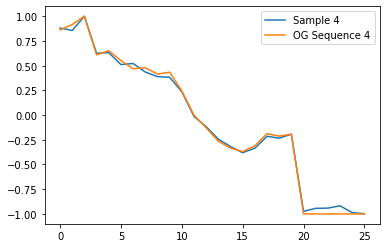

In [ ]:
sample_batchsize = 4

# Uncomment below to have determinstic sampling
g = None
# g = torch.Generator(device=device)
# g.manual_seed(0)

# Can try changing `num_inference_steps` here to check if we can diffuse a sample with fewer than DIFFUSION_TIMESTEPS steps
pipeline = SequenceDDPMPipeline(model, noise_scheduler)
pipeline = pipeline.to(device)

pipe_output = pipeline(sample_batchsize, num_inference_steps=DIFFUSION_TIMESTEPS, generator=g, return_all=True)
samples = pipe_output.sequences

for idx, smp in enumerate(samples):
  plt.plot(smp.reshape(channels, timesteps)[0].cpu(), label=f'Sample {idx + 1}')
  plt.plot(sequence[0].reshape(channels, timesteps)[0].cpu(), label=f'OG Sequence {idx + 1}')
  plt.legend()
  plt.show()

## Plotting the generation history

We can also observe the entire reverse diffusion process by plotting the history of a single channel over all the diffusion timesteps.

**Note**: For large number of diffusion timesteps, this step could take a long time.

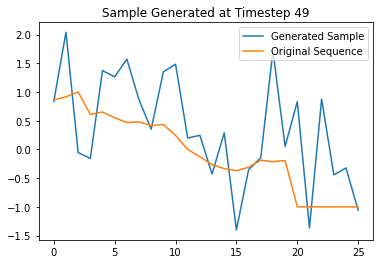

In [ ]:
hist_sample_id = 1
channel_id = 0

################################################################################
history = pipe_output.history

assert hist_sample_id < len(history), "hist_sample_id cannot be greater than number of generated samples !"
assert channel_id < channels, f"channel_id {channel_id} cannot be greater than number of channels {channels}"

# create the figure and axes objects
fig, ax = plt.subplots()

def animate_sampling_history(i):
  h = history[i]

  ax.clear()
  ax.set_title(f"Sample Generated at Timestep {DIFFUSION_TIMESTEPS - i - 1}")
  ax.plot(h[hist_sample_id, channel_id].cpu(), label=f'Generated Sample')
  ax.plot(sequence[0, channel_id].cpu(), label='Original Sequence')
  ax.legend(loc="upper right")

# run the animation
anim = FuncAnimation(fig, animate_sampling_history, frames=list(range(DIFFUSION_TIMESTEPS)), interval=200, repeat=False)

rc('animation', html='jshtml')
HTML(anim.to_jshtml())

# Conclusion

With this, we can now begin more advanced applications of diffusion models, such as conditional diffusion models, classifier free guidance training, continious time schedules, stochastic sampling and so on.

Studying diffusion on a single sample allows us to understand the challenges of each technique, and how to successfully apply them.